## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

> Implementation is from [base_example_to_try_different_implementations/from_GideonIlung_deeponet.ipynb](../../../base_example_to_try_different_implementations/from_GideonIlung_deeponet.ipynb) which is based on [DeepONet](https://github.com/GideonIlung/DeepONet) repository. This method uses `pytorch`.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [2]:
import sys
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import scipy.io as io

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Data related methods

In [4]:
class Datahandler(Dataset):
    def __init__(self, X_train_, X_trunk_, Y_train_):

        X_train = self.convert_np_to_tensor(X_train_)
        X_trunk = self.convert_np_to_tensor(X_trunk_)
        Y_train = self.convert_np_to_tensor(Y_train_)

        self.X_train = X_train
        self.X_trunk = X_trunk
        self.Y_train = Y_train

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array
    
    def __len__(self):
        return len(self.Y_train)  # Assuming X_train and X_trunk have the same length as y

    def __getitem__(self, index):
        return self.X_train[index,:], self.X_trunk, self.Y_train[index,:]

In [9]:
class DataProcessor:
    def __init__(self, batch_size, num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601):
        self.batch_size = batch_size
        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points
        self.num_Y_components = 2 # displacement field in 2D

        self.data, self.X_trunk, self.X_train, self.Y_train, \
            self.X_test, self.Y_test, self.X_train_mean, \
            self.X_train_std, self.Y_train_mean, self.Y_train_std, \
            self.tol = self.load_data()

        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)
    
    def load_data(self, tol = 1.0e-9):
        
        data = np.load(data_folder + 'LinearElasticity_samples.npz')

        # trunk input data ('xi' coordinates)
        X_trunk = data['u_mesh_nodes']
        
        # branch input data ('m' functions)
        X_train = data['m_samples'][:self.num_train,:]
        X_test = data['m_samples'][self.num_train:(self.num_train + self.num_test),:]

        X_train_mean = np.mean(X_train, 0)
        X_train_std = np.std(X_train, 0)

        X_train = (X_train - X_train_mean)/(X_train_std + tol)
        X_test = (X_test - X_train_mean)/(X_train_std + tol)

        # output data ('u' functions)
        Y_train = data['u_samples'][:self.num_train,:]
        Y_test = data['u_samples'][self.num_train:(self.num_train + self.num_test),:]

        if self.num_out_fn_points != Y_train.shape[1]:
            raise ValueError('num_out_fn_points does not match the number of output function points in the data')
        
        Y_train_mean = np.mean(Y_train, 0)
        Y_train_std = np.std(Y_train, 0)

        Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
        Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)
        
        return data, X_trunk, X_train, Y_train, X_test, Y_test, X_train_mean, X_train_std, Y_train_mean, Y_train_std, tol
        
    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        return x
    
    def encoder_Y_1d(self, x):    
        return self.encoder_Y(x)

    def decoder_Y(self, x):
        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x
    
    def decoder_Y_1d(self, x):
        return self.decoder_Y(x)
    
    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        return x
    
    def encoder_X_1d(self, x):    
        return self.encoder_X(x)
    
    def decoder_X(self, x):
        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x
    
    def decoder_X_1d(self, x):
        return self.decoder_X(x)

## Define network methods

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth,act):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        
        #the activation function#
        self.act = act 

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_size, num_classes))

        
    def forward(self, x,final_act=False):
        for i in range(len(self.layers) - 1):
            x = self.act(self.layers[i](x))
        x = self.layers[-1](x)  # No activation after the last layer

        if final_act == False:
            return x
        else:
            return torch.relu(x)

In [48]:
class DeepONet(nn.Module):
    
    def __init__(self, num_inp_fn_points, num_neurons, num_layers, \
                 num_br_outputs, num_tr_outputs, out_coordinate_dimension, num_Y_components, act):

        super(DeepONet, self).__init__()

        self.num_inp_fn_points = num_inp_fn_points
        self.num_br_outputs = num_br_outputs
        self.num_tr_outputs = num_tr_outputs
        self.out_coordinate_dimension = out_coordinate_dimension
        self.num_Y_components = num_Y_components

        #creating the branch network#
        self.branch_net = MLP(input_size=num_inp_fn_points, \
                              hidden_size=num_neurons, \
                              num_classes=num_br_outputs, \
                              depth=num_layers, \
                              act=act)
        self.branch_net.float()

        #creating the trunk network#
        self.trunk_net = MLP(input_size=out_coordinate_dimension, \
                             hidden_size=num_neurons, \
                             num_classes=num_tr_outputs, \
                             depth=num_layers, \
                             act=act)
        self.trunk_net.float()
        
        self.bias = [nn.Parameter(torch.ones((1,)),requires_grad=True) for i in range(num_Y_components)]

        self.num_Y_components = num_Y_components

        # Logger
        self.train_loss_log = []
        self.test_loss_log = []
    
    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    
    def forward(self, batch):

        X_train = self.convert_np_to_tensor(batch['X_train'])
        X_trunk = self.convert_np_to_tensor(batch['X_trunk'])
        
        branch_out = self.branch_net.forward(X_train)
        trunk_out = self.trunk_net.forward(X_trunk,final_act=True)

        output_1 = branch_out[:,:self.num_tr_outputs] @ trunk_out.t() + self.bias[0]
        output_2 = branch_out[:,self.num_tr_outputs:] @ trunk_out.t() + self.bias[1]
        output = torch.stack((output_1, output_2), dim=-1)

        return output
    
    def train(self, train_data, test_data, batch_size=32, epochs = 1000, \
              lr=0.001, log=True, \
              loss_print_freq = 100):

        self.epochs = epochs
        self.batch_size = batch_size

        dataset = Datahandler(train_data['X_train'], \
                              train_data['X_trunk'], train_data['Y_train'])
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

        X_trunk = dataset.X_trunk

        test_data_tensor = \
            {'X_train': self.convert_np_to_tensor(test_data['X_train']), \
             'X_trunk': self.convert_np_to_tensor(test_data['X_trunk']), \
             'Y_train': self.convert_np_to_tensor(test_data['Y_train']) }

        #using standard MSE loss
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))

        # Main training loop
        for epoch in range(epochs):
            
            train_losses = []
            test_losses = []

            start_time = time.perf_counter()

            for X_train, _, Y_train in dataloader:

                # X_train = X_train.numpy()
                # Y_train = Y_train.numpy()

                # print(X_train.shape, X_trunk.shape, Y_train.shape)
                batch = {'X_train': X_train, 'X_trunk': X_trunk, 'Y_train': Y_train}
                
                #removing previous gradients#
                optimizer.zero_grad()

                #forward pass through model#
                Y_train_pred = self.forward(batch)
                loss = criterion(Y_train_pred, Y_train)

                # Backward pass
                loss.backward()

                #calculate avg loss across batches#
                train_losses.append(loss.item())

                # Update parameters
                optimizer.step()

                # compute test loss
                Y_test_pred = self.forward(test_data_tensor)
                test_loss = criterion(Y_test_pred, test_data_tensor['Y_train']).item()
                test_losses.append(test_loss)

            end_time = time.perf_counter()
            epoch_time = end_time - start_time

            self.train_loss_log[epoch, 0] = np.mean(train_losses)
            self.test_loss_log[epoch, 0] = np.mean(test_losses)

            if log == True and (epoch % loss_print_freq == 0 or epoch == epochs - 1):
                print('='*30)
                print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                                  np.mean(train_losses), \
                                                  np.mean(test_losses), \
                                                  epoch_time))
                print('='*30)
    
    def predict(self, test_data):
        test_data_tensor = \
            {'X_train': self.convert_np_to_tensor(test_data['X_train']), \
             'X_trunk': self.convert_np_to_tensor(test_data['X_trunk']), \
             'Y_train': self.convert_np_to_tensor(test_data['Y_train']) }
        
        return self.forward(test_data_tensor)

## Load data

In [49]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_br_outputs = 200 # 100 for u1 and 100 for u2
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_Y_components = 2 # displacement field in 2D

#batch_size
batch_size = 100
epochs = 1000
lr = 1.0e-3

data = DataProcessor(batch_size, num_train = num_train, num_test = num_test, num_inp_fn_points = num_inp_fn_points, num_out_fn_points = num_out_fn_points)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (1900, 2601)
Y_train: (1900, 2601, 2)
X_test: (100, 2601)
Y_test: (100, 2601, 2)
X_trunk: (2601, 2)


## Create model and train the network

In [51]:
num_layers = 4
num_neurons = 128
model = DeepONet(num_inp_fn_points, num_neurons, num_layers, num_br_outputs, num_tr_outputs, out_coordinate_dimension = 2, num_Y_components = num_Y_components, act = torch.relu)

In [52]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 9.950e-01, Test Loss (l2 squared): 8.585e-01, Time (sec): 0.287
Epoch:   100, Train Loss (l2 squared): 1.082e-01, Test Loss (l2 squared): 1.058e-01, Time (sec): 0.230
Epoch:   200, Train Loss (l2 squared): 7.939e-02, Test Loss (l2 squared): 7.823e-02, Time (sec): 0.284
Epoch:   300, Train Loss (l2 squared): 6.139e-02, Test Loss (l2 squared): 5.875e-02, Time (sec): 0.256
Epoch:   400, Train Loss (l2 squared): 3.814e-02, Test Loss (l2 squared): 3.708e-02, Time (sec): 0.255
Epoch:   500, Train Loss (l2 squared): 2.764e-02, Test Loss (l2 squared): 2.660e-02, Time (sec): 0.245
Epoch:   600, Train Loss (l2 squared): 4.552e-02, Test Loss (l2 squared): 4.169e-02, Time (sec): 0.257
Epoch:   700, Train Loss (l2 squared): 1.779e-02, Test Loss (l2 squared): 1.694e-02, Time (sec): 0.232
Epoch:   800, Train Loss (l2 squared): 1.537e-02, Test Loss (l2 squared): 1.467e-02, Time (sec): 0.237
Epoch:   900, Train Loss (l2 squared): 1.720e-02, Test Loss (l2 squared):

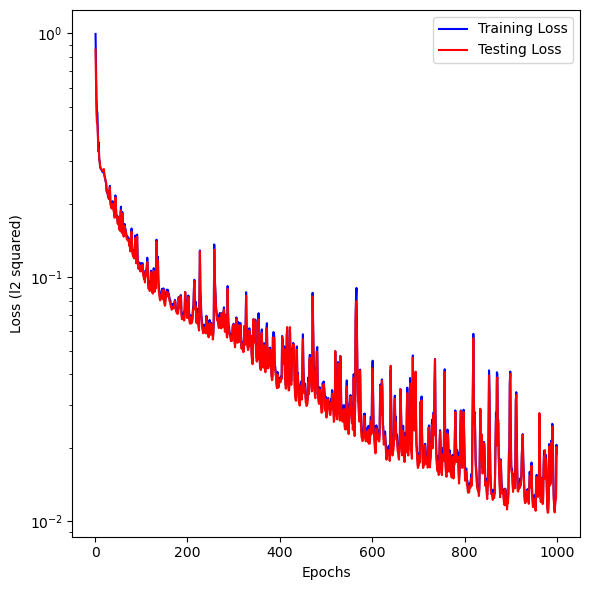

In [53]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [61]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2601, 2), test_pred shape: (100, 2601, 2)
Num tests:   100, Mean Loss (rel l2): 2.064e-01, Std Loss (rel l2): 1.748e-01


In [62]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

In [63]:
Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
i_pred = Y_test_pred[0, :, :].flatten()
u_fn = dl.Function(Vu)
u_vec = u_fn.vector().get_local()
print('u_vec shape: {}, i_pred shape: {}'.format(u_vec.shape, i_pred.shape))

u_vec shape: (5202,), i_pred shape: (5202,)


i_plot =    51, error (rel l2): 6.744e-03
i_plot =    76, error (rel l2): 8.710e-03
i_plot =    21, error (rel l2): 8.280e-03
i_plot =    28, error (rel l2): 3.942e-03
i_plot =     5, error (rel l2): 4.690e-03
i_plot =    86, error (rel l2): 4.683e-03
i_plot =    14, error (rel l2): 4.516e-03
i_plot =    93, error (rel l2): 1.413e-02
i_plot =    83, error (rel l2): 4.086e-03
i_plot =    90, error (rel l2): 3.818e-03
i_plot =    95, error (rel l2): 4.295e-03
i_plot =    94, error (rel l2): 4.480e-03
i_plot =    61, error (rel l2): 3.300e-03
i_plot =    50, error (rel l2): 3.972e-03
i_plot =    85, error (rel l2): 1.199e-02
i_plot =    91, error (rel l2): 9.248e-03


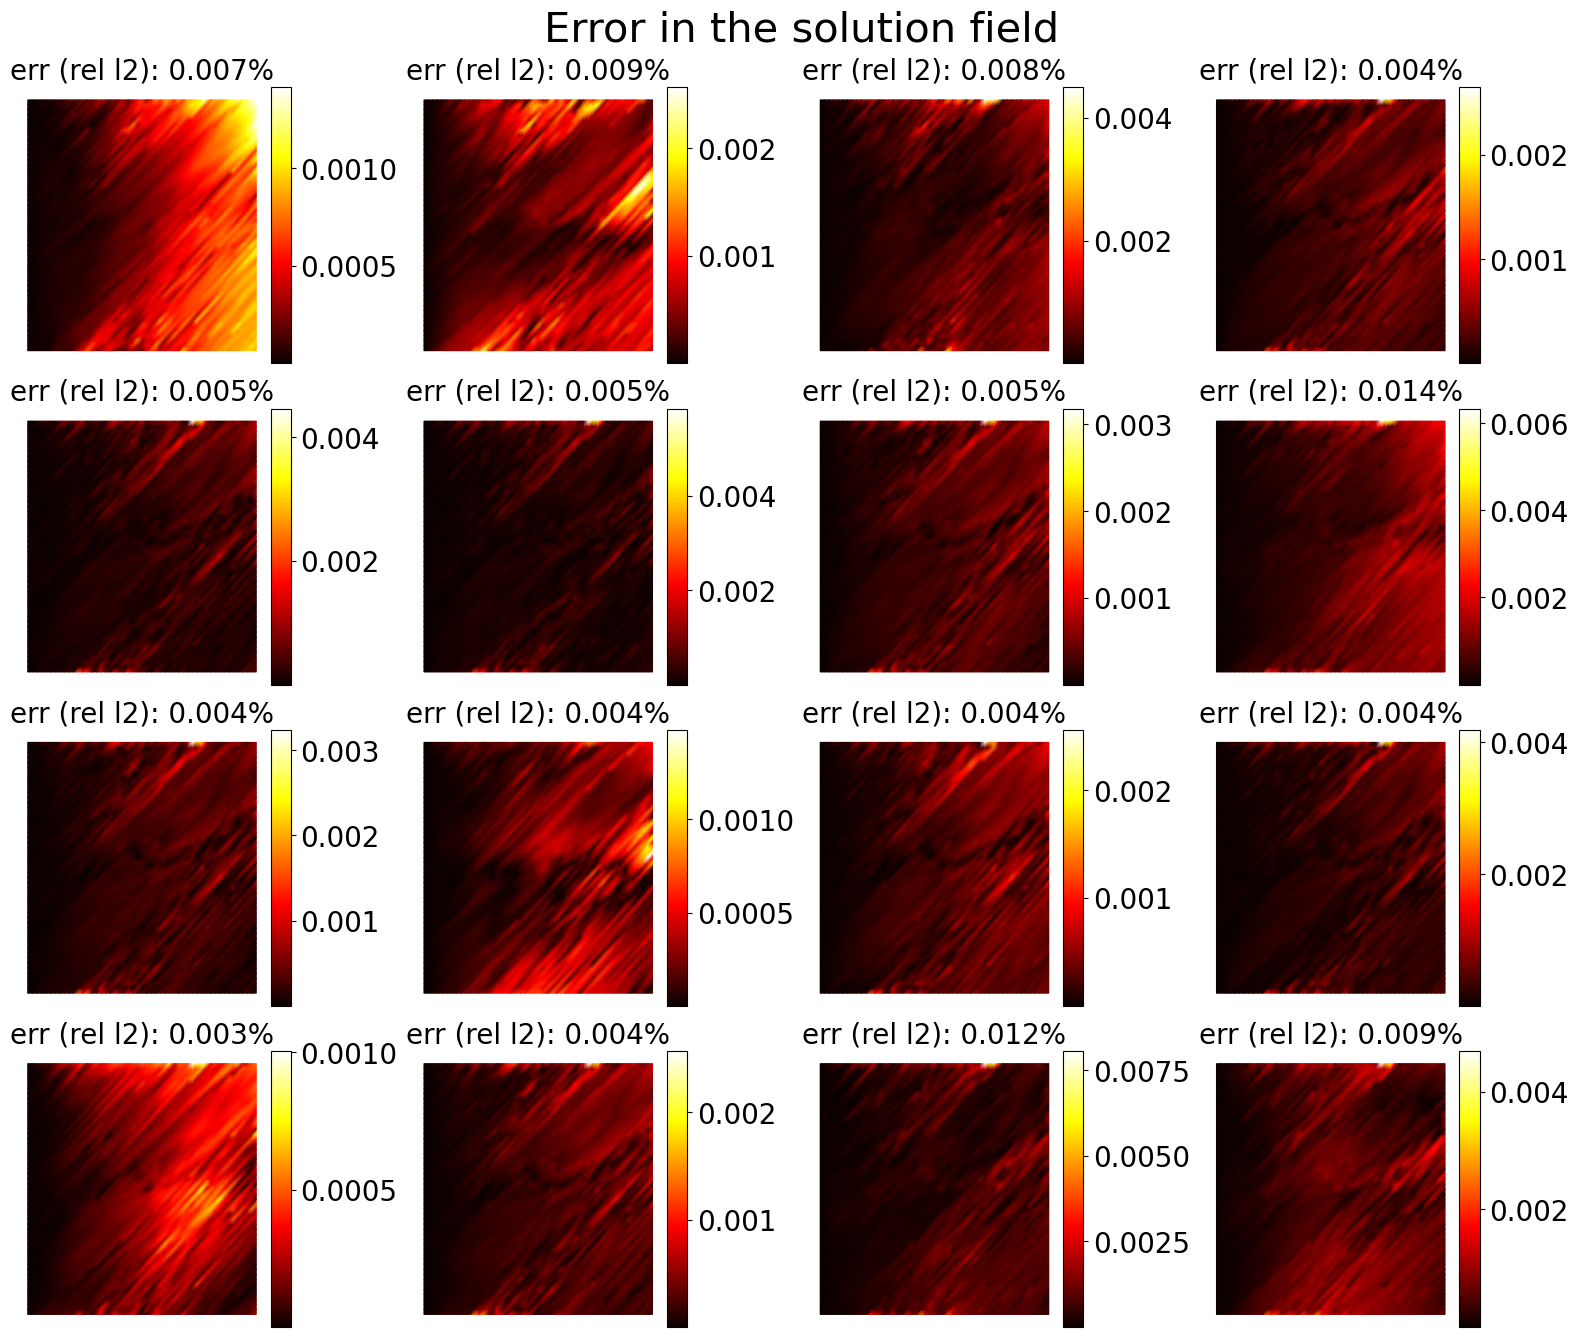

In [64]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot, :, :]
        i_truth = Y_test[i_plot, :, :]
        if decode:
            i_pred = data.decoder_Y_1d(i_pred)
            i_truth = data.decoder_Y_1d(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff.flatten(), \
                                     Vu, \
                                     cmap = 'hot', \
                                     add_displacement_to_nodes = False, \
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    14, error (rel l2): 4.516e-03
i_plot =     3, error (rel l2): 4.797e-03
i_plot =    76, error (rel l2): 8.710e-03
i_plot =    87, error (rel l2): 4.136e-03


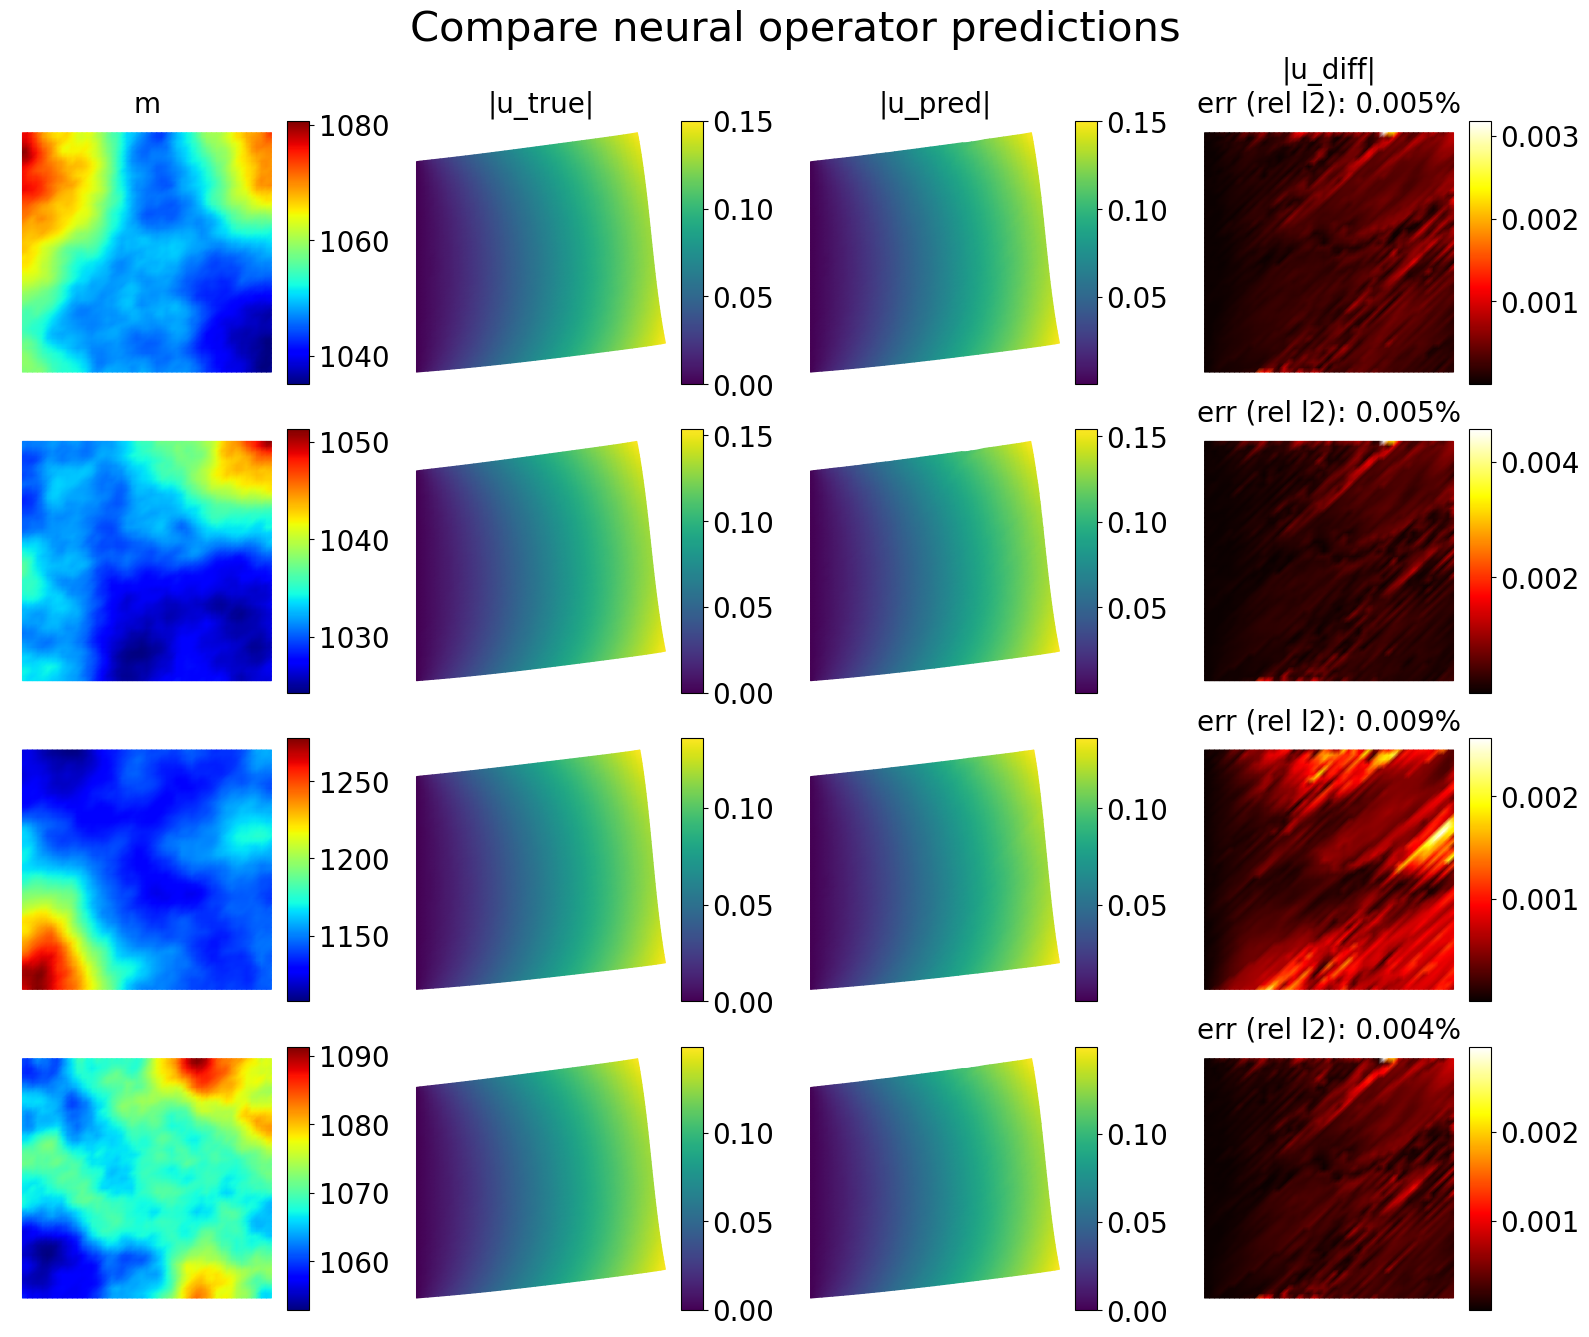

In [65]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', '|u_true|', '|u_pred|', '|u_diff|']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot, :, :]
    i_truth = Y_test[i_plot, :, :]
    i_m_test = data.X_test[i_plot, :]
    if decode:
        i_pred = data.decoder_Y_1d(i_pred)
        i_truth = data.decoder_Y_1d(i_truth)
        i_m_test = data.decoder_X_1d(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j == 0:
            cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps
            [j])
        elif j == cols - 1:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = False,\
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = True,\
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()


# Scratch

In [6]:
data = np.load(data_folder + 'LinearElasticity_samples.npz')

num_Y_components = 2 # displacement field in 2D
num_out_fn_points = 2601
num_train, num_test = 1900, 100
tol = 1.0e-9

# output data ('u' functions)
Y_train = data['u_samples'][:num_train,:]
Y_test = data['u_samples'][num_train:(num_train + num_test),:]

Y_train_mean = np.mean(Y_train, 0)
print('Y_mean shape:', Y_train_mean.shape)
Y_train_std = np.std(Y_train, 0)

Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
print('Y_train shape:', Y_train.shape)
# Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)

# return data, X_trunk, X_train, Y_train, X_test, Y_test, X_train_mean, X_train_std, Y_train_mean, Y_train_std, tol

Y_mean shape: (2601, 2)
Y_train shape: (1900, 2601, 2)


In [8]:
a = np.random.rand(4, 3, 2)

a_mean = np.mean(a, 0)
a_std = np.std(a, 0)

b = (a - a_mean)/(a_std + tol)
c = a
for i in range(a.shape[0]):
    c[i, :, :] = (a[i, :, :] - a_mean[:,:])/(a_std[:,:] + tol)

print('err: ', np.linalg.norm(b - c))



err:  0.0


In [ ]:
batch = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}

X_train = model.convert_np_to_tensor(batch['X_train'])
X_trunk = model.convert_np_to_tensor(batch['X_trunk'])
Y_train = model.convert_np_to_tensor(batch['Y_train'])

branch_out = model.branch_net.forward(X_train)
trunk_out = model.trunk_net.forward(X_trunk,final_act=True)

print('branch_out: {}, trunk_out: {}'.format(branch_out.shape, trunk_out.shape))

output_1 = branch_out[:,:num_tr_outputs] @ trunk_out.t() + model.bias[0]
output_2 = branch_out[:,num_tr_outputs:] @ trunk_out.t() + model.bias[1]
output = torch.stack((output_1, output_2), dim=-1)

print('output_1 shape: {}, output_2 shape: {}, output shape: {}'.format(output_1.shape, output_2.shape, output.shape))

criterion = nn.MSELoss()

loss = criterion(output, Y_train)
print('loss:',loss)

In [46]:
# Create two tensors
a1 = np.random.rand(2, 3)
a2 = np.random.rand(2, 3)
t1 = torch.tensor(a1)
t2 = torch.tensor(a2)

# Stack the tensors along a new dimension
t12 = torch.stack((t1, t2), dim=-1) 

print('a1')
for i in range(a1.shape[0]):
    print('i: ', i)
    print(a1[i,:])

print('\n\na2')
for i in range(a2.shape[0]):
    print('i: ', i)
    print(a2[i,:])

a12 = t12.numpy()
print('\n\na12')
for i in range(a12.shape[0]):
    print('i: ', i)
    for k in range(a12.shape[2]):
        print('k: ', k, a12[i, :, k])

a1
i:  0
[0.72999056 0.17162968 0.52103661]
i:  1
[0.05433799 0.19999652 0.01852179]


a2
i:  0
[0.7936977  0.22392469 0.34535168]
i:  1
[0.92808129 0.7044144  0.03183893]


a12
i:  0
k:  0 [0.72999056 0.17162968 0.52103661]
k:  1 [0.7936977  0.22392469 0.34535168]
i:  1
k:  0 [0.05433799 0.19999652 0.01852179]
k:  1 [0.92808129 0.7044144  0.03183893]
